In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from datasets.nuscenes import *
from datasets.carla import *

from models.evidential import *

from tools.utils import *
from tools.loss import *

%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
model = Baseline([7], backbone="lss")
model.load(torch.load("../outputs/carla/lss_baseline/9.pt"))

Loaded pretrained weights for efficientnet-b0


In [29]:
nusc, dataroot = get_nusc("mini", "../../data/nuscenes")
nusc_data = NuScenesDataset(nusc, False)

In [38]:
nusc_data = CarlaDataset("../../data/carla/val", False)

In [39]:
images, intrinsics, extrinsics, labels, ood = nusc_data[0]
images = images[None].to(7)
intrinsics = intrinsics[None].to(7)
extrinsics = extrinsics[None].to(7)
labels = labels[None].to(7)

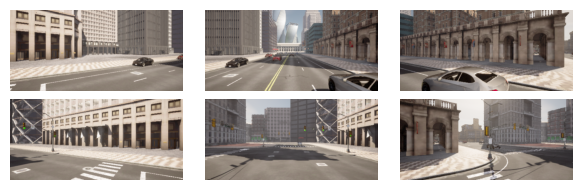

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(6, 2))

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    image = images[0, i].cpu().permute(1, 2, 0).numpy()
    ax.imshow(image)

plt.tight_layout()
plt.savefig('cameras.png', transparent=True)

In [41]:
logits = model(images, intrinsics, extrinsics).detach().cpu()
preds = model.activate(logits)

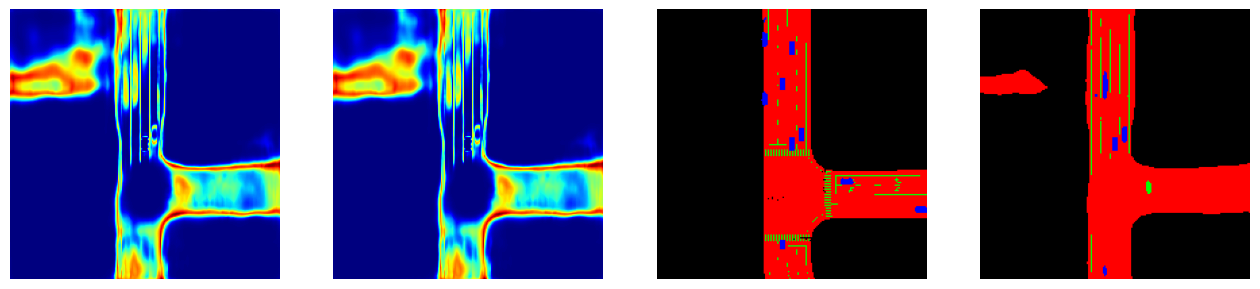

In [49]:
s = 16
fig, axs = plt.subplots(1, 4, figsize=(s, s * 4))

axs[0].imshow(model.aleatoric(logits)[0, 0], cmap='jet')
axs[1].imshow(model.epistemic(logits)[0, 0], cmap='jet')
axs[2].imshow(map_rgb(labels[0]) / 255)
axs[3].imshow(map_rgb(preds[0]) / 255)

for ax in axs.flatten():
    ax.axis("off")

1.7431765794754028


(-0.5, 199.5, 199.5, -0.5)

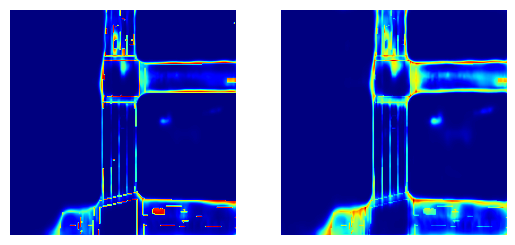

In [28]:
loss = ce_loss(preds.cpu(), labels.cpu())[0].numpy()
print(loss.max())
loss /= loss.max()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(loss, cmap='jet')
axs[0].axis("off")
axs[1].imshow(loss * model.aleatoric(logits)[0, 0].numpy(), cmap='jet')
axs[1].axis("off")

1.0


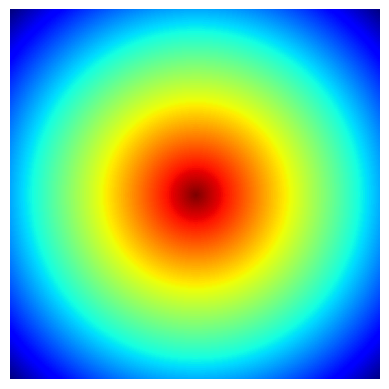

In [76]:
k = np.ones((200, 200))
k = generate_array(200)

plt.imshow(k, cmap='jet')
plt.axis("off")
print(k.max())

In [75]:
def generate_array(size):
    indices = np.indices((size, size))
    
    center_x = size // 2
    center_y = size // 2
    
    distances = np.sqrt((indices[0] - center_x)**2 + (indices[1] - center_y)**2)
    distances /= distances.max()
    array = 1 - distances
    
    return array